In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_1 = '/content/drive/MyDrive/fake_news_classification_project/Datasets/real_news.csv'
path_2 = '/content/drive/MyDrive/fake_news_classification_project/Datasets/fake_news.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load Dataset

In [ ]:
# load dataset from Google Drive
def load_data():
    file_1 = pd.read_csv(path_1, index_col=0)
    file_2 = pd.read_csv(path_2, index_col=0)
    # add new column named label for each dataframes
    file_1['category'] = "Nyata" # for real news
    file_2['category'] = "Palsu" # for fake news
    return file_1, file_2
real_news, fake_news = load_data()

In [ ]:
# copy dataframes (for test) and drop null values
df_1 = real_news.copy(deep=True).dropna(axis='rows')
df_2 = fake_news.copy(deep=True).dropna(axis='rows')

In [ ]:
# merge two dataframes and reset index
df = pd.concat([df_1, df_2]).reset_index(drop=True)

df = df.drop(columns=['Ringkasan', 'URL'])
df = df.rename(columns={"Judul":"title", "Teks":"text", "Publikasi":"publish_date"})

df

,title,text,publish_date,category
0,"Angka Perkawinan Anak Meroket di Ponorogo, May...",--\n\nJumlah angka perkawinan anak dengan alas...,2023-01-13 13:43:37,Nyata
1,Polri Sebut WNI Papua Pemilik Senpi Ilegal Dip...,--\n\nMabes Polri menyatakan WNI asal Papua An...,2023-01-13 13:31:17,Nyata
2,"Gempa Magnitudo 3,6 Guncang Karangasem Bali","--\n\nGempa bumi berkekuatan 3,6 magnitudo men...",2023-01-13 13:24:50,Nyata
3,5 Pendiri Kelompok Pemuja Setan di Dunia,--\n\nKelompok pemuja setan The Satanic Temple...,2023-01-13 12:39:44,Nyata
4,"Ganti Komandan, Agresi Putin di Ukraina Disebu...",--\n\nPresiden Rusia Vladimir Putin memutuskan...,2023-01-13 11:22:14,Nyata
...,...,...,...,...
16755,[BENAR] Pihak Kepolisian dan The Jakmania Bant...,Debunk ini berisi informasi tentang adanya swe...,2018-09-24 00:00:00,Palsu
16756,[KLARIFIKASI] BMKG TANGGAPI RAMALAN GEMPA DAN ...,SUMBER : SITUS RESMI BMKG\n\nhttp://www.bmkg.g...,2018-01-02 00:00:00,Palsu
16757,[SALAH] Kotoran Putih Pada Bayi Baru Lahir Dap...,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,2022-05-01 00:00:00,Palsu
16758,[SALAH] Akun Facebook Wakil Walikota Surabaya ...,Hasil periksa fakta Rahmah An Nisaa (Uin Sunan...,2021-01-10 00:00:00,Palsu


Palsu    8720
Nyata    8040
Name: category, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


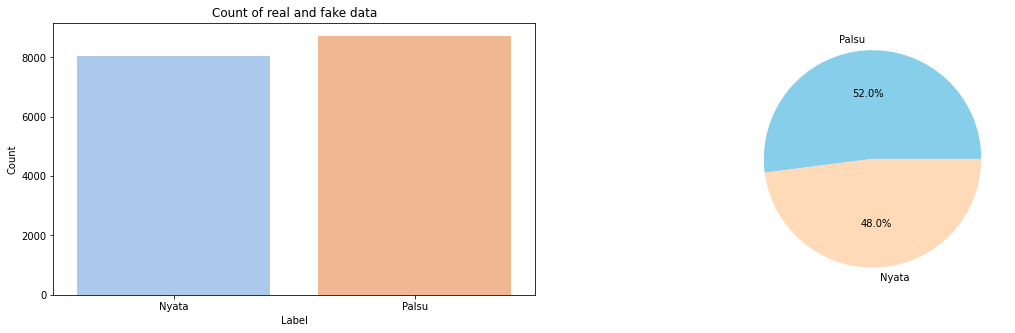

In [ ]:
print(df["category"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df.category,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Label")
g2 = plt.pie(df["category"].value_counts().values,explode=[0,0],labels=df.category.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

In [ ]:
df['combined_text'] = df['title'] + " " + df['text']
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df

,title,text,publish_date,category,combined_text
0,[SALAH] Foto McDonalds “Hey Crypto Bro’s WE AR...,Hasil Periksa Fakta Renanda Dwina Putri (Anggo...,2022-01-31 00:00:00,Palsu,[SALAH] Foto McDonalds “Hey Crypto Bro’s WE AR...
1,"Haaland Ngotot Cabut dari Man City, Real Madri...",--\n\nReal Madrid dikabarkan siap menampung Er...,2023-02-09 12:40:28,Nyata,"Haaland Ngotot Cabut dari Man City, Real Madri..."
2,[SALAH] Petinggi PKS Merapat ke Jokowi karena ...,"Bukan petinggi PKS, tetapi silaturahmi antara ...",2020-07-23 00:00:00,Palsu,[SALAH] Petinggi PKS Merapat ke Jokowi karena ...
3,[SALAH] Pasukan Taliban Mengendarai “Cyber Tru...,Hasil Periksa Fakta Renanda Dwina Putri (Anggo...,2021-10-25 00:00:00,Palsu,[SALAH] Pasukan Taliban Mengendarai “Cyber Tru...
4,Kanker CELL CURE RS Gatot Subroto Jakarta – Tu...,Hasil periksa fakta Riza Dwi (Anggota Tim Kali...,2022-03-18 00:00:00,Palsu,Kanker CELL CURE RS Gatot Subroto Jakarta – Tu...
...,...,...,...,...,...
16755,[SALAH] Mata Uang Baru Kadrun 212 dengan Foto ...,Hasil Periksa Fakta Rizky Abdul Aziz (Anggota ...,2020-08-23 00:00:00,Palsu,[SALAH] Mata Uang Baru Kadrun 212 dengan Foto ...
16756,[SALAH] “jokowi pewaris indonesia krn beliau c...,Tangkapan layar yang digunakan post SUMBER ada...,2019-01-06 00:00:00,Palsu,[SALAH] “jokowi pewaris indonesia krn beliau c...
16757,[SALAH] Foto Jokowi Mengenakan Kemeja Merah Be...,Unggahan akun Facebook Rambo Tiger atau @rambo...,2020-05-04 00:00:00,Palsu,[SALAH] Foto Jokowi Mengenakan Kemeja Merah Be...
16758,[SALAH] Foto Spanduk “KAMI OPTIMIS PAK JOKOWI ...,Foto yang tersebar merupakan hasil editan. Fot...,2019-02-07 00:00:00,Palsu,[SALAH] Foto Spanduk “KAMI OPTIMIS PAK JOKOWI ...


# Removal of Special Character and Punctuation

In [ ]:
from bs4 import BeautifulSoup

def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
df['title'] = df['title'].apply(lambda x: remove_html(x))
df['text'] = df['text'].apply(lambda x: remove_html(x))

In [ ]:
# define a regular expression pattern to match emoticons
emoticon_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                              "]+", flags=re.UNICODE)

def remove_punct(text):
    # remove URL from string
    text = text = re.sub(r'(https?://[^\s]+)', ' ', text)

    # remove user tags (e.g., @username)
    text = re.sub(r'@\w+', ' ', text)

    # remove hashtags (e.g., #hashtag)
    text = re.sub(r'#\w+', ' ', text)

    # remove the emoticons from the text
    text = re.sub(emoticon_pattern, ' ', text)

    # remove the text inside square brackets [], parentheses (), and curly braces {}
    text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', ' ', text)

    # remove unwanted sentences in real news
    text = text.replace('ADVERTISEMENT SCROLL TO RESUME CONTENT', ' ')

    # remove (') from words
    text = text.replace("'", "")

    # remove (\n) from text
    text = text.replace("\n", " ")

    # remove punctuation and special character
    text = re.sub(r'[^\w\s]', ' ', text)

    # remove non-alphabetic words
    text = re.sub(r'\b[^a-zA-Z]+\b', ' ', text)

    # remove digit number
    text = re.sub(r'\d+', ' ', text)

    # lower the text
    text = text.lower()

    return text

In [ ]:
df['title'] = df['title'].apply(lambda x: remove_punct(x))
df['text'] = df['text'].apply(lambda x: remove_punct(x))

# Removal of Stopwords and Stemming

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 6.1 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
#Removal of stopwords and stemming
def remove_stopwords_and_stemming(text):
    final_text = []
    text = word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('indonesian')):
            word = stemmer.stem(word)
            final_text.append(word)

    return " ".join(final_text)

In [ ]:
df['title'] = df['title'].apply(lambda x: remove_stopwords_and_stemming(x))
df['text'] = df['text'].apply(lambda x: remove_stopwords_and_stemming(x))

In [ ]:
df['combined_text'] = df['title'] + " " + df['text']
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df

,title,text,publish_date,category,combined_text
0,ojk suara jam dagang bursa normal pandemi,otoritas jasa uang buka suara pasti jam dagang...,2022-12-30 00:57:21,Nyata,ojk suara jam dagang bursa normal pandemi otor...
1,update pek gempa turki suriah,gempa dahsyat guncang turki suriah senin gempa...,2023-02-11 06:07:13,Nyata,update pek gempa turki suriah gempa dahsyat gu...
2,tim putri indo vs tim putri rusia turnbackhoax id,sumber sebar kali tangkap layar akun akun seba...,2018-01-20 00:00:00,Palsu,tim putri indo vs tim putri rusia turnbackhoax...
3,jokowi heran ri butuh pupuk pabrik setop produksi,presiden joko widodo pt pupuk iskandar muda ac...,2023-02-10 21:58:36,Nyata,jokowi heran ri butuh pupuk pabrik setop produ...
4,camat lampung red zone covid turnbackhoax id,hasil periksa fakta indri pramesti widyaningru...,2020-03-27 00:00:00,Palsu,camat lampung red zone covid turnbackhoax id h...
...,...,...,...,...,...
16755,warga korea selatan vaksin ikut milu turnbackh...,hasil periksa fakta nadine salsabila lansir af...,2022-01-24 00:00:00,Palsu,warga korea selatan vaksin ikut milu turnbackh...
16756,tragedi pesawat jatuh nepal dekade,mei orang tewas celaka pesawat agni air ziarah...,2023-01-16 11:30:57,Nyata,tragedi pesawat jatuh nepal dekade mei orang t...
16757,periksa dito mahendra kpk usut aset eks sekret...,komisi berantas korupsi usut duga alir uang as...,2023-02-06 16:10:38,Nyata,periksa dito mahendra kpk usut aset eks sekret...
16758,meni istri cerai suami gara gara dukung jokowi...,judul sunting edit judul asli menit meni istri...,2020-07-22 00:00:00,Palsu,meni istri cerai suami gara gara dukung jokowi...


In [ ]:
df.to_csv('/content/drive/MyDrive/FND_Project/Datasets/clean_text_with_stemming.csv')

# Text Augmentation

In [ ]:
!pip install transformers[tf-cuda]

In [ ]:
!pip install indobenchmark-toolkit

In [ ]:
import torch
from transformers import GPT2LMHeadModel
from indobenchmark import IndoNLGTokenizer

In [ ]:
gpt_model = GPT2LMHeadModel.from_pretrained('indobenchmark/indogpt')
gpt_tokenizer = IndoNLGTokenizer.from_pretrained('indobenchmark/indogpt')

In [ ]:
for param in gpt_model.parameters():
    param.requires_grad = False

In [ ]:
def generate_text(input_text):
    max_new_tokens = 50
    gpt_input = gpt_tokenizer.prepare_input_for_generation(input_text, model_type='indogpt', return_tensors='pt')
    if len(gpt_input['input_ids'][0]) < 300:
        max_length = len(gpt_input['input_ids'][0]) + max_new_tokens
        gpt_out = gpt_model.generate(**gpt_input, do_sample=True, max_length=max_length, pad_token_id=gpt_tokenizer.eos_token_id, num_return_sequences=1)
        generated_text = gpt_tokenizer.decode(gpt_out[0])
    else:
        generated_text = input_text

    return generated_text

In [ ]:
text = generate_text(sentences['clean_text'][0])
text

In [ ]:
# Add generated texts to the dataframe
sentences['generated_text'] = sentences['clean_text'].apply(lambda x: generate_text(x))
sentences['generated_text']

In [ ]:
sentences['generated_text'] = sentences['generated_text'].apply(lambda x: remove_stopwords_and_stemming(x))

In [ ]:
sentences['generated_text']

In [ ]:
df = df.dropna(axis='rows')
df = df.sample(frac=1).reset_index(drop=True)
df